First step in my exploration is to read data, print some quick summary statistics and draw some graphs. To do this, I'll use Pandas library which provides data structures and tools that make manipulating data very simple and effective.

#### Features list

In [1]:
allFeatures  = ['ADLOADINGTIME', 'ACCOUNTID', 'CAMPAIGNID', 'CREATIVEID', 'PLACEMENTID',
       'TIMESTAMP', 'PLATFORM', 'PLATFORMVERSION', 'EXTERNALADSERVER',
       'EXTERNALCREATIVEID', 'EXTERNALPLACEMENTID', 'EXTERNALSITEID',
       'EXTERNALSUPPLIERID', 'INTENDEDDEVICETYPE', 'ACTUALDEVICETYPE', 'SDK',
       'HOSTWINDOWHEIGHT', 'HOSTWINDOWWIDTH', 'TOPMOSTREACHABLEWINDOWHEIGHT',
       'TOPMOSTREACHABLEWINDOWWIDTH', 'DEVICEORIENTATION', 'NETWORKTYPE',
       'CDNNAME', 'CREATIVETYPE', 'GEOIP_LNG', 'GEOIP_LAT', 'GEOIP_TIMEZONE',
       'GEOIP_COUNTRY', 'GEOIP_REGION', 'GEOIP_CITY', 'GEOIP_AREACODE',
       'GEOIP_METROCODE', 'GEOIP_DMACODE', 'UA_HARDWARETYPE', 'UA_DEVICETYPE',
       'UA_MOBILEDEVICE', 'UA_PLATFORM', 'UA_PLATFORMVERSION', 'UA_VENDOR',
       'UA_MODEL', 'UA_OS', 'UA_OSVERSION', 'UA_BROWSER', 'UA_BROWSERVERSION',
       'UA_BROWSERRENDERINGENGINE', 'FILESJSON', 'ERRORSJSON']

## Features I dont consider, since they are too customer specific.
dontConsider = ['ACCOUNTID', 'CAMPAIGNID', 'CREATIVEID', 'PLACEMENTID', 'EXTERNALADSERVER',
               'EXTERNALCREATIVEID', 'EXTERNALPLACEMENTID', 'EXTERNALSITEID', 'EXTERNALSUPPLIERID']

## Accumulating list of potentionally good features and discarded features
learnFeatures = []
discardedFeatures = []


#### Helper method for manipulating dataframes

In [2]:
import pandas as pd

## pandas crashed while reading more than one million lines in one batch, so I split 
## the data in two files and read them seperately then append them into one DataFrame
def getFullDataFrame(features):
    df1 = pd.read_csv("largeFirst.tsv", delimiter="\t", low_memory=False, usecols=features)
    df2 = pd.read_csv("largeSecond.tsv", delimiter="\t", low_memory=False, usecols=features)
    df = df1.append(df2, ignore_index = True)
    return df

## Returns new dataframe with features selected
def pickColumnsDataFrame(df, features):
    df2 = df.copy()
    return df2[features]

#### Read data into dataframe

In [3]:
potentionalFeatures = list(set(allFeatures) - set(dontConsider))
df = getFullDataFrame(potentionalFeatures)

#### Plotting our target variable

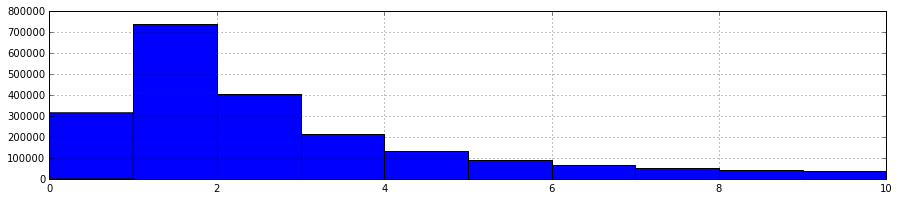

In [4]:
%matplotlib inline

df[(df['ADLOADINGTIME'] > 0) & (df["ADLOADINGTIME"] <= 10)]['ADLOADINGTIME'].hist(figsize=(15,3))

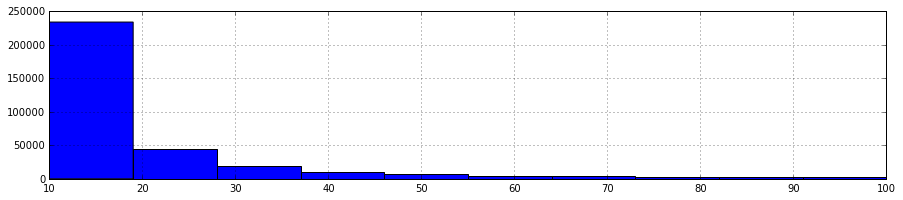

In [5]:
df[(df['ADLOADINGTIME'] > 10) & (df["ADLOADINGTIME"] <= 100)]['ADLOADINGTIME'].hist(figsize=(15,3))

We see, that almost all rows have 'ADLOADINGTIME' smaller than 50. Lets now calculate how many outliers are present  in the data

In [6]:
numRows = 2450000
for i in [10, 30, 50, 100, 1000]:
    x = len(df[df['ADLOADINGTIME'] >= i])
    y = str(round((x/numRows*100),2)) + "%"
    print("Number of rows with ADLOADINGTIME >= %s is %s   ---> %s of rows included" % (i, x, y))

Number of rows with ADLOADINGTIME >= 10 is 356074   ---> 14.53% of rows included
Number of rows with ADLOADINGTIME >= 30 is 71395   ---> 2.91% of rows included
Number of rows with ADLOADINGTIME >= 50 is 43771   ---> 1.79% of rows included
Number of rows with ADLOADINGTIME >= 100 is 24037   ---> 0.98% of rows included
Number of rows with ADLOADINGTIME >= 1000 is 1575   ---> 0.06% of rows included


We can see that number of rows quickly falls as we are increasing the ADLOADINGTIME. There are less than 3% of rows with ADLOADINGTIME >= 30.

#### Extract some potentional features for boxploting

In [7]:
def getPotentionalColumns(df, columns, unique_bound, lower):
    candidates = []
    print("Extracting columns with less than " + str(unique_bound)+ " and more than " + str(lower) + " features...")
    df1 = pickColumnsDataFrame(df, columns)
    
    for column in df1:
        num_uniques = len(df[column].unique())
        if num_uniques < unique_bound and num_uniques > lower:
            print (column, num_uniques)
            candidates.append(column)
            
    return candidates

candidates = getPotentionalColumns(df, potentionalFeatures, 20, 1)

Extracting columns with less than 20 and more than 1 features...
CREATIVETYPE 7
NETWORKTYPE 3
UA_BROWSERRENDERINGENGINE 10
ERRORSJSON 17
UA_DEVICETYPE 4
INTENDEDDEVICETYPE 3
ACTUALDEVICETYPE 4
UA_HARDWARETYPE 12
SDK 5
UA_MOBILEDEVICE 2
UA_OS 9
CDNNAME 3
DEVICEORIENTATION 5
PLATFORM 8
UA_PLATFORM 7


#### Plotting some intereseting features

While plotting, I had to remove outliers in 'ADLOADINGTIME' in order to get readable plot. The cutting line for outliers was set at 30, which means I excluded around 3% of data.

In [8]:
def prepareForPlot(df, applyLambda):
    df2 = df.copy()
    feature = df2.columns[1]
    if applyLambda == True:
        df2['ADLOADINGTIME'] = df2['ADLOADINGTIME'].apply(lambda x: 30 if x > 30 else x)
    for value in df2[feature].unique():
        df2[value] = df2[df2[feature] == value]['ADLOADINGTIME']
    df2 = df2.drop('ADLOADINGTIME', 1)
    df2 = df2.drop(feature, 1)
    return df2

def summarize(df):
    feature = df.columns[1]
    print(df.groupby(feature).mean())
    df = prepareForPlot(df, True)
    df.plot.box(figsize=(17,6))
    
    
def present(column):
    df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', column])
    summarize(df1)

                 ADLOADINGTIME
PLATFORM                      
Android               7.978140
BlackBerry            8.894497
DesktopPlatform       6.272564
IOS                  14.951107
WAPBrowser            1.562260
WebOS                65.821000
WindowsPhone          8.740721
null                  3.687539


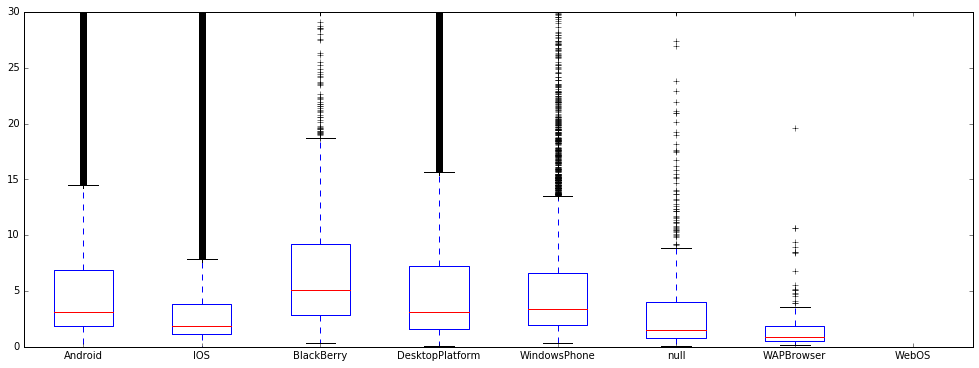

In [9]:
present('PLATFORM')
learnFeatures.append('PLATFORM')

We can see that PLATFORM affects ADLOADINGTIME. WAPBrowser on one side with best results (low mean, low variance) and BlackBerry on other side with worst (big mean, big variance). Because of differences in distribution, PLATFORM should definetly be added to learningFeatures. Outlier in this plot is WebOS, which has no values in our range from 0-30. However as seen below, WebOS is present in only one row and is therefore pretty insignificant. 

In [10]:
df[df['PLATFORM'] == 'WebOS']

,ADLOADINGTIME,TIMESTAMP,PLATFORM,PLATFORMVERSION,INTENDEDDEVICETYPE,ACTUALDEVICETYPE,SDK,HOSTWINDOWHEIGHT,HOSTWINDOWWIDTH,TOPMOSTREACHABLEWINDOWHEIGHT,...,UA_PLATFORMVERSION,UA_VENDOR,UA_MODEL,UA_OS,UA_OSVERSION,UA_BROWSER,UA_BROWSERVERSION,UA_BROWSERRENDERINGENGINE,FILESJSON,ERRORSJSON
26411,65.821,1459538818,WebOS,3.0.5,Tablet,Tablet,MobileWeb,0,0,942,...,3.0.5,HP,TouchPad,WebOS,3.0.5,webOS Browser,234.83,WebKit,"[{""type"":""image"",""size"":13989},{""type"":""image""...",[]


             ADLOADINGTIME
NETWORKTYPE               
mobile            3.821632
null             11.493369
wifi              3.563467


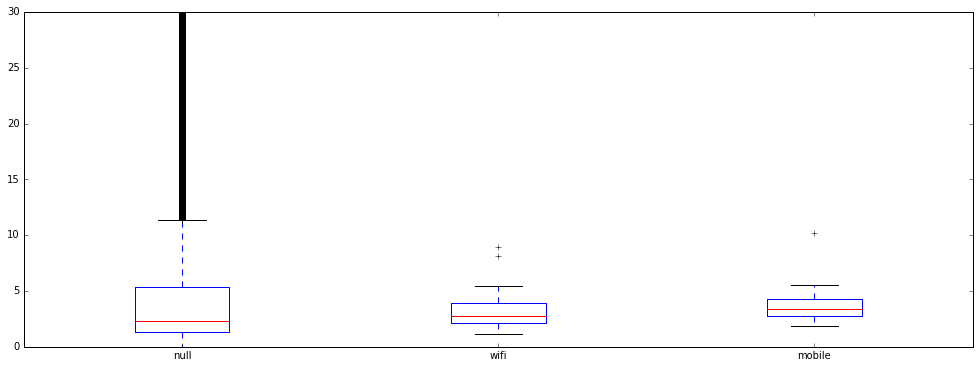

In [11]:
present('NETWORKTYPE')
learnFeatures.append('NETWORKTYPE')
discardedFeatures.append('UA_PLATFORM')

Wifi and mobile have pretty stable ADLOADINGTIME with low mean and variance, while 'null' is pretty unstable. Our model can probably learn something from this feature

                  ADLOADINGTIME
ACTUALDEVICETYPE               
Desktop                6.259990
Phone                  8.453040
Tablet                45.956643
null                  10.934511


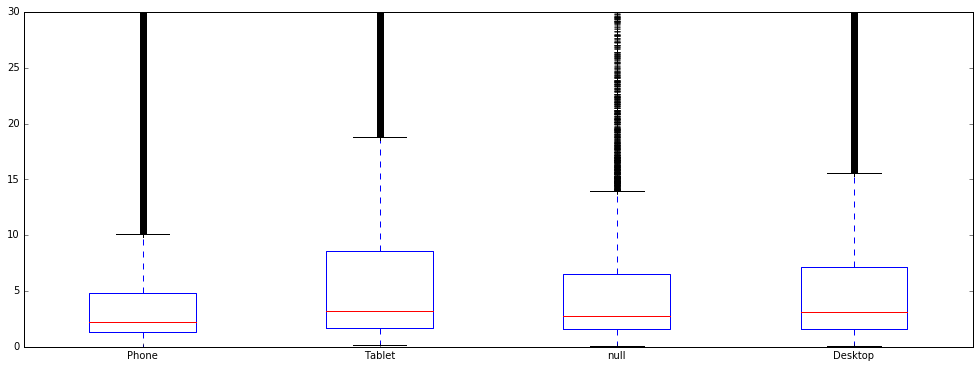

In [12]:
present('ACTUALDEVICETYPE')
learnFeatures.append('ACTUALDEVICETYPE')
discardedFeatures.append('INTENDEDDEVICETYPE')
discardedFeatures.append('UA_DEVICETYPE')

We can see that tablet's performance is pretty bad compared to Phone and Desktop. This is pretty obvious from the mean printed above. Since Tablet is in more than 200000 lines, this is clearly an important feature to keep. INTENDEDDEVICETYPE and UA_DEVICETYPE on other hand, yields pretty similar results thus can be ignored.

In [13]:
df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'INTENDEDDEVICETYPE'])
print("Number of rows with Tablet: " + str(len(df[df['ACTUALDEVICETYPE'] == 'Tablet'])))
print()
print(df1.groupby('INTENDEDDEVICETYPE').mean())

Number of rows with Tablet: 213074

                    ADLOADINGTIME
INTENDEDDEVICETYPE               
Desktop                  6.820517
Phone                    8.380754
Tablet                  69.789365


                           ADLOADINGTIME
CREATIVETYPE                            
Banner                          5.681240
ExpandableBanner               13.244411
InstaAdVideoInterscroller       4.745339
InstaAdVideoInterstitial        5.874288
Interscroller                   8.193597
Interstitial                   20.479534
Reveal                          4.566977


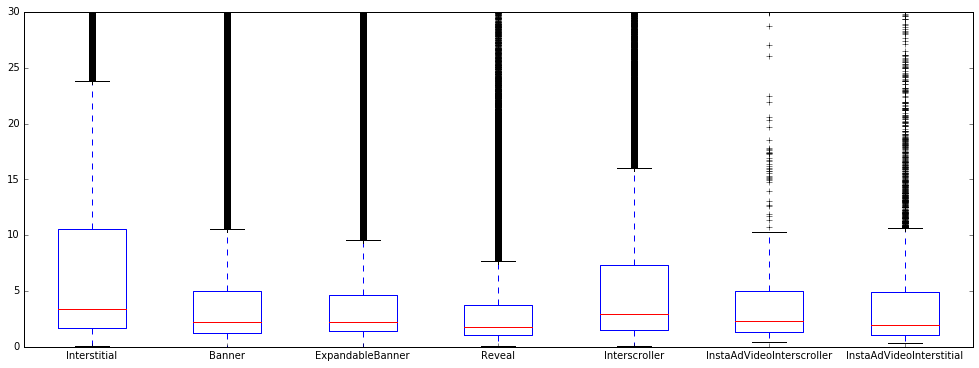

In [14]:
present('CREATIVETYPE')
learnFeatures.append('CREATIVETYPE')

#### Summary

I have only plotted a few of features that I have found interesting. After doing more plotting and analysis, I have extracted features seen below. Some of them were pretty obvious, while I was a bit sceptical about others.
For example DEVICEORIENTATION gave pretty equal results for all values except 'null'. In my opinion this can tell us something about device. For example device is old and dont have gyroscope, while others have it. These features are also not too expensive for one-hot I intend to do, since they have low number of unique values.

In [15]:
toAdd = ['UA_OS', 'SDK', 'UA_MOBILEDEVICE', 'UA_BROWSERRENDERINGENGINE', 'UA_HARDWARETYPE', 'CDNNAME', 'DEVICEORIENTATION']
learnFeatures = learnFeatures + toAdd
print(learnFeatures)

['PLATFORM', 'NETWORKTYPE', 'ACTUALDEVICETYPE', 'CREATIVETYPE', 'UA_OS', 'SDK', 'UA_MOBILEDEVICE', 'UA_BROWSERRENDERINGENGINE', 'UA_HARDWARETYPE', 'CDNNAME', 'DEVICEORIENTATION']


#### Lets analyze other features with higher number of unique values

In [16]:
candidates = getPotentionalColumns(df, potentionalFeatures, 100, 20)

Extracting columns with less than 100 and more than 20 features...
UA_BROWSER 38


                          ADLOADINGTIME
UA_BROWSER                             
AOL Browser                    4.647949
Amazon Silk                   10.433807
Android Browser                9.883669
BlackBerry Browser             9.269818
Chrome                         6.729692
Chrome Mobile                  7.764691
Chromium                      10.159553
Comodo Dragon                  6.516273
Dolfin                         4.365000
Edge                           5.880922
Firefox                        7.712355
Iceweasel                      4.770529
Internet Explorer              6.067394
Internet Explorer Mobile       9.036800
Iron                           7.115385
Kindle Browser                 1.917000
MIUI Browser                  21.399182
Maxthon                        5.575286
NetFront                      10.610000
Nintendo Browser               9.949857
Nokia Browser                  9.198333
Nokia S40 Browser              6.016500
Nokia S60 Browser              9.879833


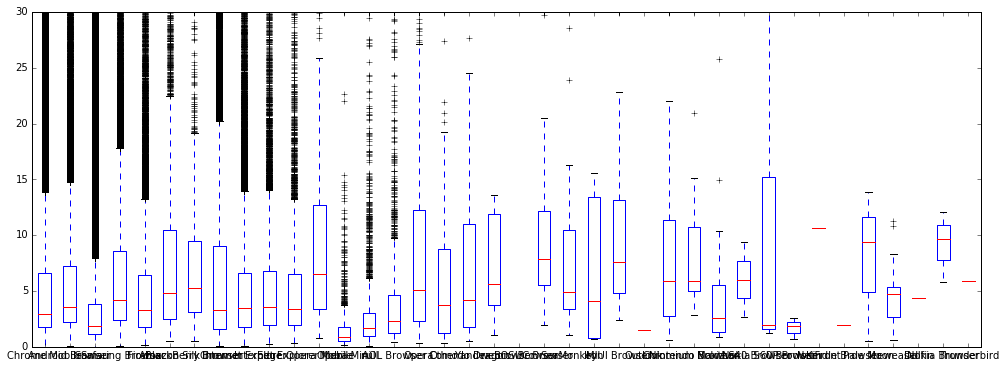

In [17]:
present('UA_BROWSER')
learnFeatures.append('UA_BROWSER')

What we see here is that that UA_BROWSER for some values gives pretty accurate predictions with low variance. I checked if the outliers could be because of low numbers of row, but Safari for example give pretty high ADLOADINGTIME and is present in more than 50% of rows.

#### Get last batch of candidates.

In [32]:
candidates = getPotentionalColumns(df, potentionalFeatures, 400, 100)

Extracting columns with less than 400 and more than 100 features...
GEOIP_AREACODE 284
GEOIP_TIMEZONE 274
GEOIP_METROCODE 211
PLATFORMVERSION 147
GEOIP_DMACODE 211
UA_OSVERSION 212
GEOIP_COUNTRY 201
UA_PLATFORMVERSION 145


At this point, my boxplot fails. These features are too diverse to plot. However I am fairly confident that location features have correlation with ADLOADINGTIME. After all, internet connection is very depandant on our location and how close we are to transmitter. However, there are 5 features for location above. I will use only 'GEOIP_COUNTRY', 'GEOIP_TIMEZONE' and 'GEOIP_AREACODE' at this point. Country and Timezone are global, but Areacode is USA specific. DMACODE and AREACODE are also USA specific and probably highly dependable with AREACODE. This leaves us with UA_OSVERSION and PLATFORMVERSION. 

In [66]:
locationFeatures = ['GEOIP_AREACODE', 'GEOIP_COUNTRY', 'GEOIP_TIMEZONE',
                     'GEOIP_REGION']
learnFeatures = learnFeatures + locationFeatures
discardedFeatures.append('GEOIP_LAT')
discardedFeatures.append('GEOIP_LNG')

In [48]:
df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'UA_OSVERSION'])
x = df1.groupby('UA_OSVERSION')
print(x.max()[70:80], x.mean()[70:80])

              ADLOADINGTIME
UA_OSVERSION               
2.3.2                14.272
2.3.3               267.236
2.3.4               551.697
2.3.5               340.404
2.3.6               846.163
2.3.7               224.659
2.4                   2.639
21                  316.875
22                    5.775
23                   10.764               ADLOADINGTIME
UA_OSVERSION               
2.3.2             10.295500
2.3.3             14.366554
2.3.4              8.032583
2.3.5              9.733428
2.3.6             10.224002
2.3.7             15.868762
2.4                2.639000
21                38.720778
22                 2.631267
23                 4.620250


In [49]:
df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'PLATFORMVERSION', 'UA_OSVERSION', 'UA_PLATFORMVERSION'])
df1[:10]

,ADLOADINGTIME,PLATFORMVERSION,UA_OSVERSION,UA_PLATFORMVERSION
0,21.730,4.4.2,4.4.2,4.4.2
1,2.753,4.3,4.3,4.3
2,12.962,4.1.2,4.1.2,4.1.2
3,7.121,4.3,4.3,4.3
4,4.301,4.4.2,4.4.2,4.4.2
5,11.175,4.4.2,4.4.2,4.4.2
6,9.833,4.1.2,4.1.2,4.1.2
7,2.614,4.4.2,4.4.2,4.4.2
8,2.610,4.4.2,4.4.2,4.4.2
9,58.080,5.1.1,5.1.1,5.1.1


We can see that PLATFORMVERSION, UA_OSVERSION, UA_PLATFORMVERSION are columns with same values, so I will drop two of them, keeping only PLATFORMVERSION.

In [53]:
learnFeatures.append('PLATFORMVERSION')
discardedFeatures.append('UA_PLATFORMVERSION')
discardedFeatures.append('UA_OSVERSION')

#### Remaining features

In [54]:
print(set(potentionalFeatures) - set(learnFeatures))

{'GEOIP_REGION', 'GEOIP_AREACODE', 'UA_MODEL', 'GEOIP_TIMEZONE', 'UA_BROWSERVERSION', 'TIMESTAMP', 'GEOIP_METROCODE', 'GEOIP_DMACODE', 'UA_OSVERSION', 'ERRORSJSON', 'UA_VENDOR', 'UA_DEVICETYPE', 'GEOIP_COUNTRY', 'GEOIP_CITY', 'INTENDEDDEVICETYPE', 'TOPMOSTREACHABLEWINDOWWIDTH', 'HOSTWINDOWWIDTH', 'GEOIP_LAT', 'UA_PLATFORMVERSION', 'FILESJSON', 'ADLOADINGTIME', 'GEOIP_LNG', 'UA_PLATFORM', 'HOSTWINDOWHEIGHT', 'TOPMOSTREACHABLEWINDOWHEIGHT'}


#### Analyze FILEJSON and ERRORJSON

            ADLOADINGTIME
ERRORSJSON               
0               14.191874
1                6.434997
2                7.806471
3                5.318995


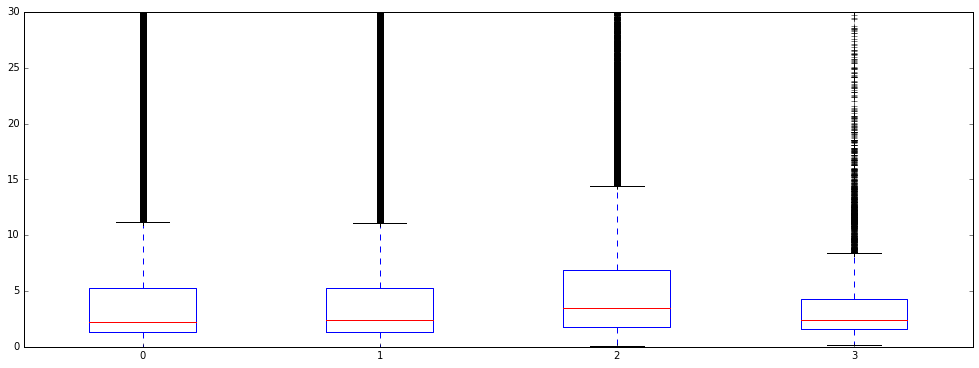

In [55]:
import json  

df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'ERRORSJSON'])
df1['ERRORSJSON'] = df['ERRORSJSON'].apply(lambda x: len(json.loads(x)))

summarize(df1)

In [56]:
df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'FILESJSON'])

def getFilesSize(x):
    d = json.loads(x)
    acc = 0
    for file in d:
        acc += int(file['size'])
    return acc

df1['FILESJSON'] = df1['FILESJSON'].apply(lambda x: getFilesSize(x))

print(df1[df1['FILESJSON'] < 1000000].mean()[0])
print(df1[df1['FILESJSON'] > 1000000].mean()[0])
print(df1.corr().head(1))
discardedFeatures.append('ERRORSJSON')
discardedFeatures.append('FILESJSON')

11.5463414291
5.67489832498
               ADLOADINGTIME  FILESJSON
ADLOADINGTIME            1.0  -0.000041


I decided to map both FILESJSON and ERRORJSON in numeric feature. ERRORJSON mapped to length doesn't give any unique information as seen on graph above. Higher mean value at 0 is result of some outliers. I would expect that FILESJSON mapped to sum of file sizes would bring some good predictions. However correlation between two continious variables is very small so I decided to discard both FILESJSON and ERRORSJSON.

#### Transform timestamp into other features


In [57]:
from datetime import datetime

def timestampToList(timestamp):
    return str(datetime.fromtimestamp(
        int(timestamp)
    ).strftime('%m %w %H')).split(' ')


## returns dataframe with features ['MONTH', 'DAY_OF_WEEK', 'HOUR_OF_DAY']
def extractTimestamp(df):
    df1 = pickColumnsDataFrame(df, ['ADLOADINGTIME', 'TIMESTAMP'])
    timestamps = df1['TIMESTAMP']
    accMonth = []
    accDay = []
    accHour = []
    for timestamp in timestamps:
        parsed = timestampToList(timestamp)
        accMonth.append(int(parsed[0]))
        accDay.append(int(parsed[1]))
        hour_of_day = int(parsed[2])
        accHour.append(int(hour_of_day / 4))



    df1 = df1.drop('TIMESTAMP', 1)
    df1['MONTH'] = accMonth
    df1['DAY_OF_WEEK'] = accDay
    df1['HOUR_OF_DAY'] = accHour
    return df1

df1 = extractTimestamp(df)

#### Hour of day

             ADLOADINGTIME
HOUR_OF_DAY               
0                 8.757908
1                 8.015213
2                 7.927288
3                 8.158107
4                23.391727
5                 9.566060


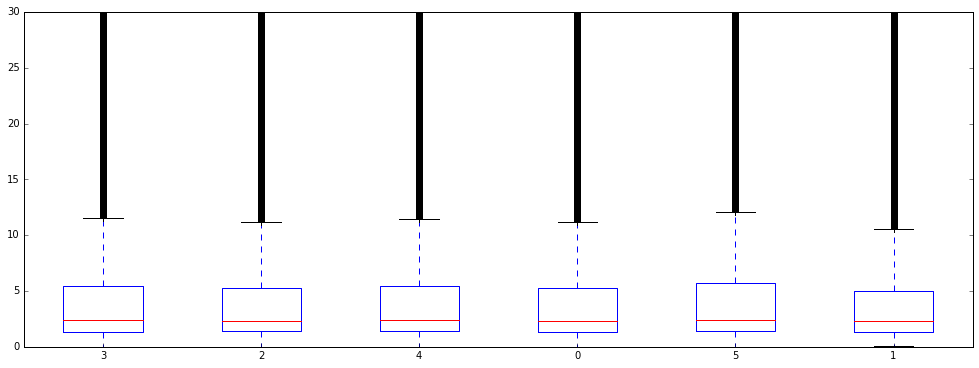

In [58]:
df2 = pickColumnsDataFrame(df1, ['ADLOADINGTIME', 'HOUR_OF_DAY'])
summarize(df2)

In [28]:
df2[df2['ADLOADINGTIME'] > 100000]

,ADLOADINGTIME,HOUR_OF_DAY
1254543,7430398.56,4


There is one outlier which makes mean() a bit shaky, but in general hour_of_day doesnt tell us anything valuable. Story is similar with DAY_OF_WEEK, meaning we can't extract any good predictions from these two.

#### Month

       ADLOADINGTIME
MONTH               
1           4.855506
2           4.344907
3           7.679248
4           8.418845
5           8.297728
6      116104.381516
7        4549.424368
8           3.482250
9         858.310333
10         20.161944
11          5.057687
12          3.380679


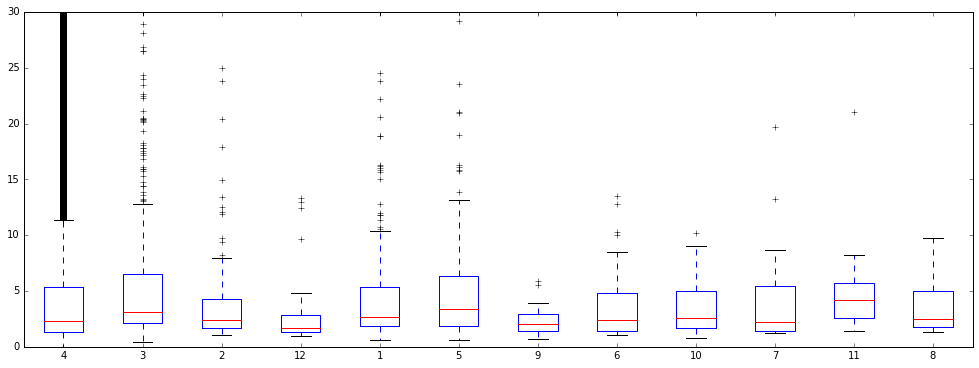

In [59]:
df2 = pickColumnsDataFrame(df1, ['ADLOADINGTIME', 'MONTH'])
summarize(df2)

In [61]:
print(df2[df2['MONTH'] == 4].shape)
discardedFeatures.append('TIMESTAMP')

(2448822, 2)


Months looked more promising on graph, but after finding out almost all rows from dataset are from april, I came to conclusion that we don't have enough data about other monts to make any good predictions.

In [67]:
discardedFeatures.append('UA_VENDOR')
discardedFeatures.append('UA_MODEL')
discardedFeatures.append('UA_BROWSERVERSION')
print(set(potentionalFeatures) - set(learnFeatures) - set(discardedFeatures))


{'GEOIP_METROCODE', 'GEOIP_CITY', 'ADLOADINGTIME', 'TOPMOSTREACHABLEWINDOWWIDTH', 'GEOIP_DMACODE', 'TOPMOSTREACHABLEWINDOWHEIGHT'}


I did some analysis on 'UA_BROWSERVERSION', 'UA_VENDOR'  and 'UA_MODEL' and found they dont have any relevant correlation with 'ADLOADINGTIME. What we are left at this point is screen size.

#### Analyze screen size

In [6]:
def columnToNumeric(df, column):
    df1 = pickColumnsDataFrame(df, [column])
    df1 = df1.loc[df[column] != 'null']
    df1[column] = pd.to_numeric(df1[column])
    df1 = df1.abs()
    x = df1.loc[df1[column] < 20000].mean()[0]
    
    df1 = pickColumnsDataFrame(df, [column])
    df1[df1[column] == 'null'] = str(x)
    df1[column] = pd.to_numeric(df1[column])
    return df1


df1 = pickColumnsDataFrame(df, ['HOSTWINDOWHEIGHT', 'HOSTWINDOWWIDTH'])
df1['HOSTWINDOWHEIGHT'] = columnToNumeric(df1, 'HOSTWINDOWHEIGHT')
df1['HOSTWINDOWWIDTH'] = columnToNumeric(df1, 'HOSTWINDOWWIDTH')

#### Lets try adding a new feature - surface

In [64]:
df1['SURFACE'] = df1['HOSTWINDOWHEIGHT'] * df1['HOSTWINDOWWIDTH']
learnFeatures.append('HOSTWINDOWWIDTH')
discardedFeatures.append('HOSTWINDOWHEIGHT')
df2 = pickColumnsDataFrame(df, ['ADLOADINGTIME'])
result = pd.concat([df2, df1],axis = 1)
result.corr().head(1)

,ADLOADINGTIME,HOSTWINDOWHEIGHT,HOSTWINDOWWIDTH,SURFACE
ADLOADINGTIME,1.0,-0.000006,0.001162,-0.000004


We can see that height and surface are uncorelated while width have much higher correlation. Therefore, i will discard height and surface and add width as a final feature to my learningFeatures.

#### Feature Engineering done

At this point I have reduced number of feature to less than half. I had problems with this, since I couldn't find any good method to check correlation with categorial features. One-Way ANOVA in python doesn't take categorical features and didn't work properly for me. I probably should have used R for analysing the data but I kinda had no time since I never used R before. Anyway, I think that boxplots are fairly good indicator of correlation and are also way more interesting than just some number output.

In [19]:
learnFeatures = ['PLATFORM', 'NETWORKTYPE', 'ACTUALDEVICETYPE', 'CREATIVETYPE', 'UA_OS', 'SDK',
               'UA_MOBILEDEVICE', 'UA_BROWSERRENDERINGENGINE', 'UA_HARDWARETYPE', 'CDNNAME',
               'DEVICEORIENTATION', 'UA_BROWSER', 'GEOIP_COUNTRY',
               'GEOIP_TIMEZONE',
               'GEOIP_REGION', 'PLATFORMVERSION', 'HOSTWINDOWWIDTH', 'ADLOADINGTIME']

#### Machine learning

Since most of the features are categorical and almost all scikit algorithms take numerical features only, I will use One-Hot combined with Label Encoding to transform dataset to numeric.

In [4]:
from sklearn import preprocessing
def labelEncodeDataFrame(df):
    df1 = df.copy()
    le = preprocessing.LabelEncoder()
    for feature in df1:
        if(df1[feature].dtype == "object"):
            le.fit(df1[feature])
            df1[feature] = list(le.transform(df1[feature]))
    return df1


#### One-hot encode dataframe into sparse matrix

In [7]:
from sklearn.preprocessing import OneHotEncoder

def labelEncodeFeatures(learnFeatures):
    df = getFullDataFrame(learnFeatures)
    df['HOSTWINDOWWIDTH'] = columnToNumeric(df, 'HOSTWINDOWWIDTH')
    df = labelEncodeDataFrame(df)
    return df
    
def oneHot(df):
    df = pickColumnsDataFrame(df, learnFeatures)
    
    ## Mask numerical features, by default One-Hot treats all as categorical features
    mask = [True] * len(df.columns)
    cols = list(df.columns.values)
    mask[cols.index('HOSTWINDOWWIDTH')] = False
    mask[-1] = False ## Last column is ADLOADINGTIME
    enc = OneHotEncoder(categorical_features=mask)
    enc.fit(df)
    return enc.transform(df)
    
df = labelEncodeFeatures(learnFeatures)
df = oneHot(df)

#### Split data into train_test

In [8]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(df, test_size = 0.1)


train_x, target = train[:, :-1], train[:,-1].toarray()
test_x, test_y = test[:, :-1], test[:,-1].toarray()


#### Linear models

In [9]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def rmse(x, y):
    return mean_squared_error(x, y) ** 0.5


#### Lets train our models [Linear Regression, Ridge, Elastic Net]

In [26]:
regr = linear_model.LinearRegression(n_jobs=4)
modelLinear = regr.fit(train_x, target)

clf = linear_model.Ridge (alpha = .5)
modelRidge = clf.fit(train_x, target)

enet = linear_model.ElasticNet(alpha=0.1, l1_ratio=0.7)
modelElastic = enet.fit(train_x, target)

#### Predictions

Since I have linear model predictions can be negative. However, ADLOADINGTIME can't be negative, so I replace negative predictions with some low positive number (1), which improves RMSE a bit.

In [52]:
print("Linear Regression RMSE:")
predictions = modelLinear.predict(test_x)
predictions[predictions < 0] = 1
print(rmse(test_y, predictions))
print("-------------------------")
print("Ridge RMSE:")
predictions = modelRidge.predict(test_x)
predictions[predictions < 0] = 1
print(rmse(test_y, predictions))
print("-------------------------")
print("Elastic Net RMSE:")
predictions = modelElastic.predict(test_x)
predictions[predictions < 0] = 1
print(rmse(test_y, predictions))

Linear Regression RMSE:
53.2832436516
-------------------------
Ridge RMSE:
51.4529575604
-------------------------
Elastic Net RMSE:
52.1628665149


#### Sanity check

In [54]:
predictions = modelLinear.predict(train_x)
predictions[predictions < 0] = 1
print("Linear Regression RMSE on train data:")
print(rmse(target, predictions))

Linear Regression RMSE on train data:
5005.213684


I'm really confused about this right now. Predictions on training set are 100 times higher than predictions on test set. I think this shouldn't be possible and predictions on set you train on should allways be better, so I'm not sure if I have bug in code or there are so many outliers. In either case, I ran out of time to tackle this problem.